In [1]:
# Import Basis
import pandas as pd 
import optuna
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
# Remove Warnings
import warnings 
warnings.filterwarnings("ignore")

from scipy.stats import skew  
# import Subplots
from plotly.subplots import make_subplots
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Model Classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler , StandardScaler 

from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from catboost import CatBoostClassifier
from sklearn.metrics import *

# Classifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Set the option to display all columns
pd.set_option('display.max_columns', None)

print("Done")

Done


In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [3]:
print("train data shape is :", train.shape) 
print("test data shape is :", test.shape) 

train data shape is : (5898, 15)
test data shape is : (2528, 14)


In [4]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    summ['top value'] = desc['top'].values
    summ['Freq'] = desc['freq'].values

    return summ

summary(train)

,data type,#missing,Duplicate,#unique,min,max,avg,std dev,top value,Freq
ID,int64,0,0,5898,10002.0,99998.0,54964.183452,26133.640949,NaN,NaN
Loan_ID,object,0,0,457,NaN,NaN,NaN,NaN,LP002585,767
Gender,int64,0,0,2,0.0,1.0,0.910817,0.285032,NaN,NaN
Married,int64,0,0,2,0.0,1.0,0.854527,0.352607,NaN,NaN
Dependents,object,0,0,4,NaN,NaN,NaN,NaN,0,3659
Education,int64,0,0,2,0.0,1.0,0.12021,0.325235,NaN,NaN
Self_Employed,int64,0,0,2,0.0,1.0,0.107664,0.309981,NaN,NaN
ApplicantIncome,int64,0,0,3708,150.0,81000.0,7782.026958,9182.571831,NaN,NaN
CoapplicantIncome,float64,0,0,3121,0.0,20000.0,1245.954548,2368.012349,NaN,NaN
LoanAmount,int64,0,0,343,17.0,700.0,97.410478,103.483478,NaN,NaN


In [5]:
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Dependents', "Property_Area", 'Credit_History']
numerical_columns = ['LoanAmount','Loan_Amount_Term','Total_Income','CoapplicantIncome', 'ApplicantIncome']
target = 'Loan_Status'

In [6]:
train[numerical_columns].describe()

,LoanAmount,Loan_Amount_Term,Total_Income,CoapplicantIncome,ApplicantIncome
count,5898.000000,5898.000000,5898.000000,5898.000000,5898.000000
mean,97.410478,359.114954,5239.284503,1245.954548,7782.026958
std,103.483478,48.876088,2308.679455,2368.012349,9182.571831
min,17.000000,12.000000,1963.000000,0.000000,150.000000
25%,17.000000,357.000000,3750.000000,0.000000,2342.250000
50%,42.000000,368.000000,6000.000000,117.562275,6989.000000
75%,174.000000,372.000000,6000.000000,1680.894542,8375.000000
max,700.000000,480.000000,22500.000000,20000.000000,81000.000000


In [7]:

def showplot(columnname):
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = train[columnname].value_counts()
    labels = value_counts.index.tolist()
    colors =["#4caba4", "#d68c78",'#a3a2a2','#ab90a0', '#e6daa3', '#6782a8', '#8ea677']
    
    # Donut Chart
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%',textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
        wedgeprops=dict(width=0.35),  startangle=80,   pctdistance=0.85  )
    # circle
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)
    
    # Count Plot
    sns.countplot(data=train, y=columnname, ax=ax[1], palette=colors, order=labels)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 1, i, str(v), color='black',fontsize=10, va='center')
    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9,color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

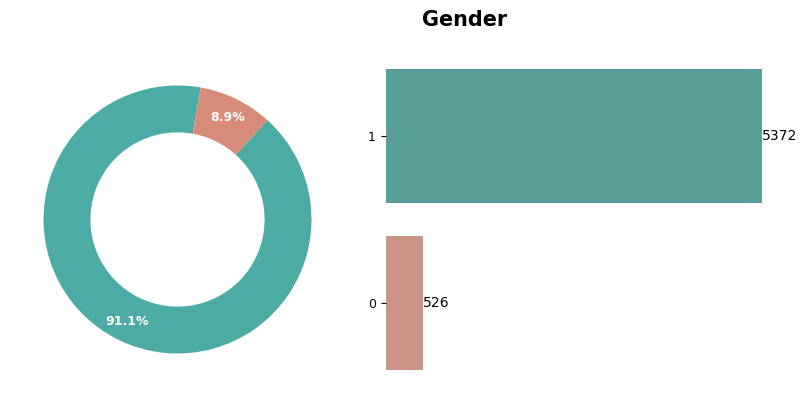

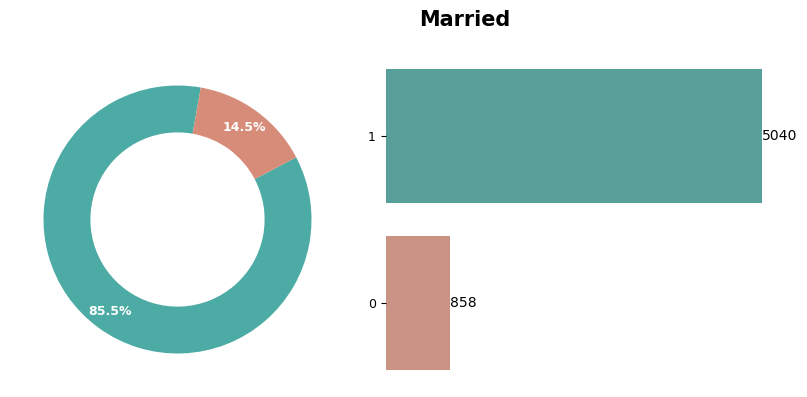

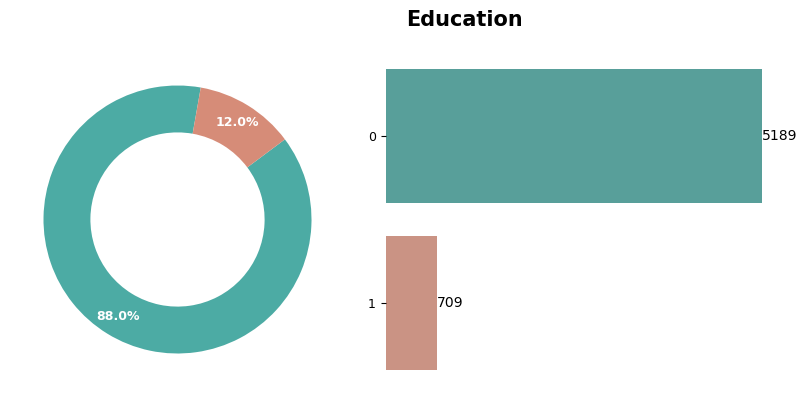

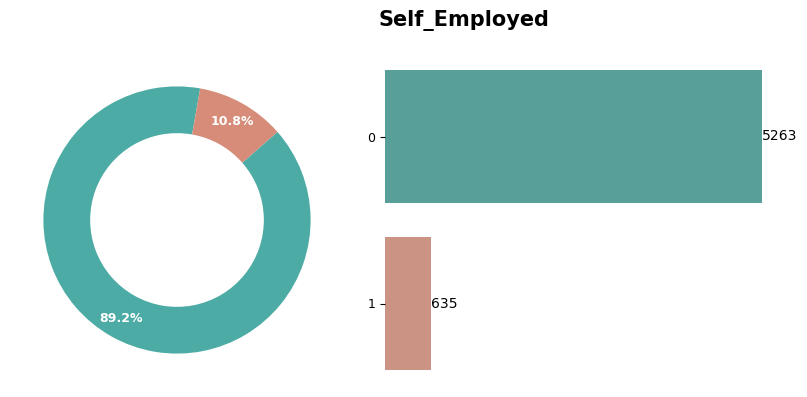

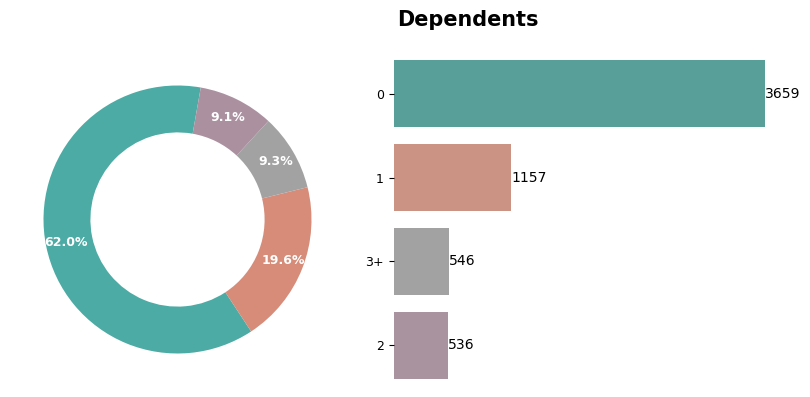

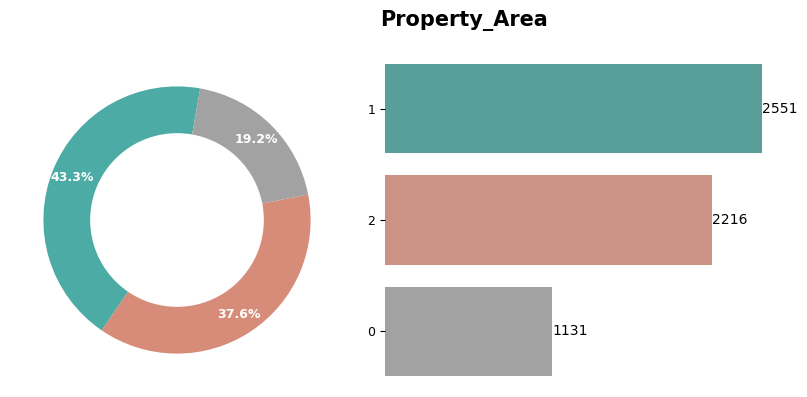

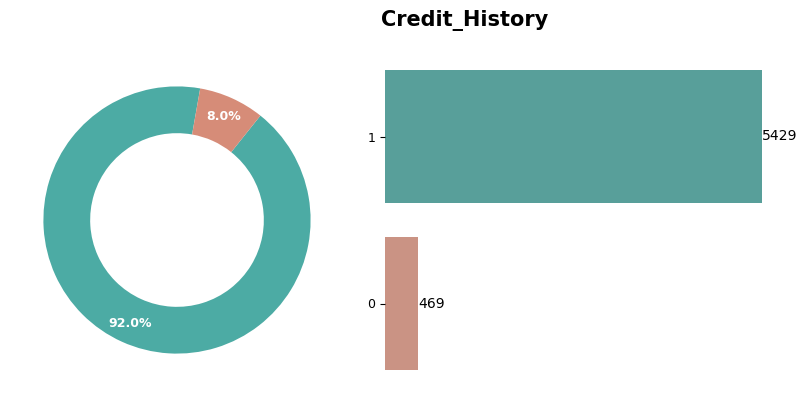

In [8]:
for col in categorical_columns:
    showplot(col)

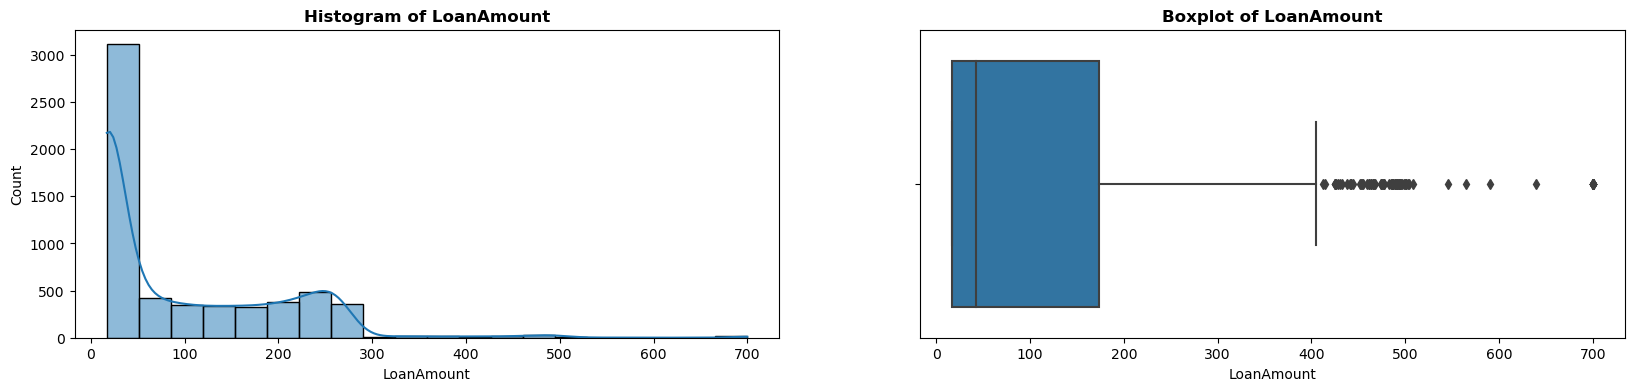

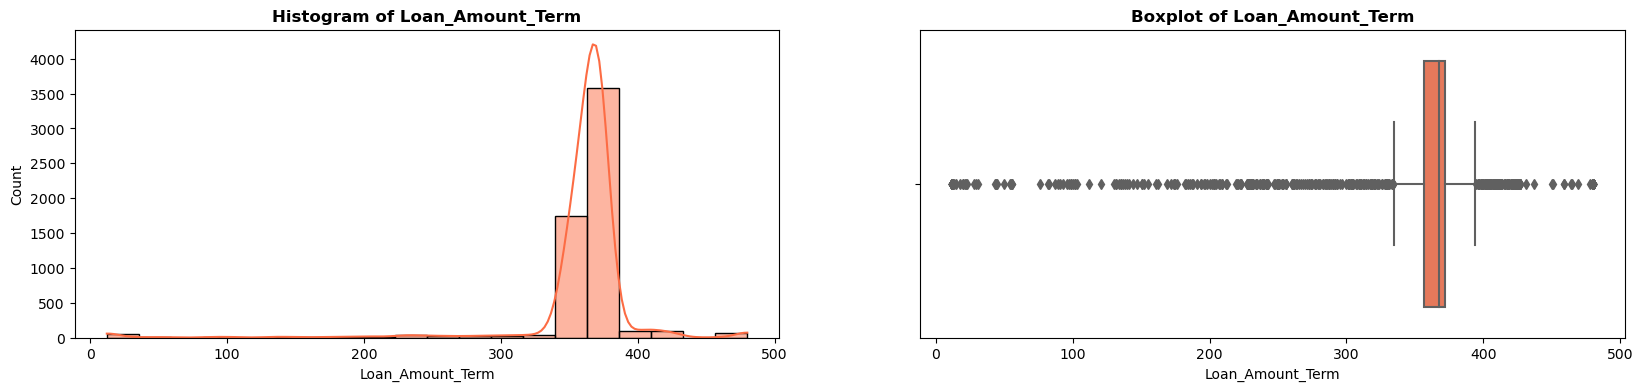

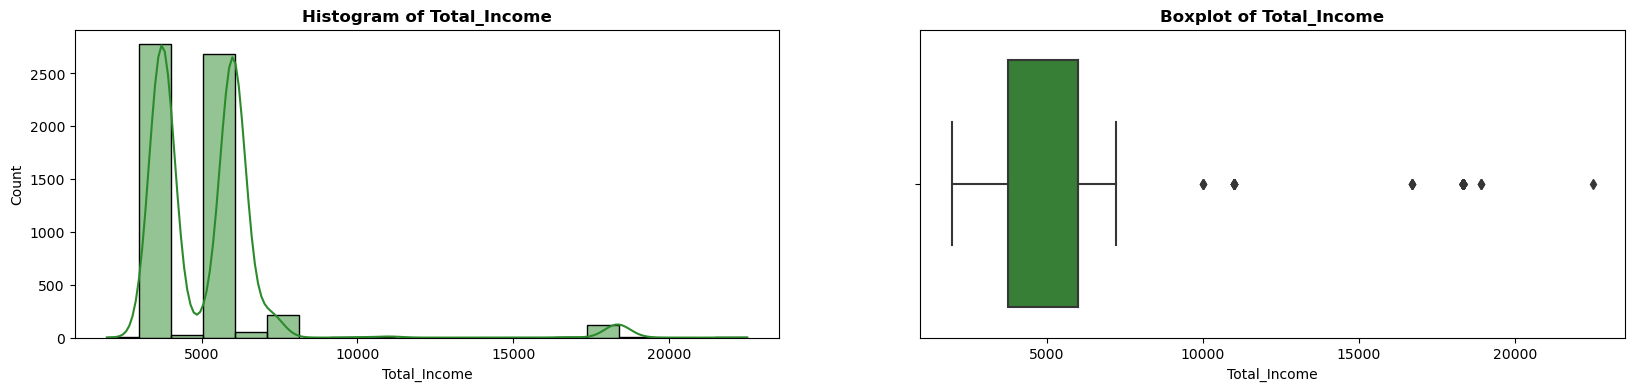

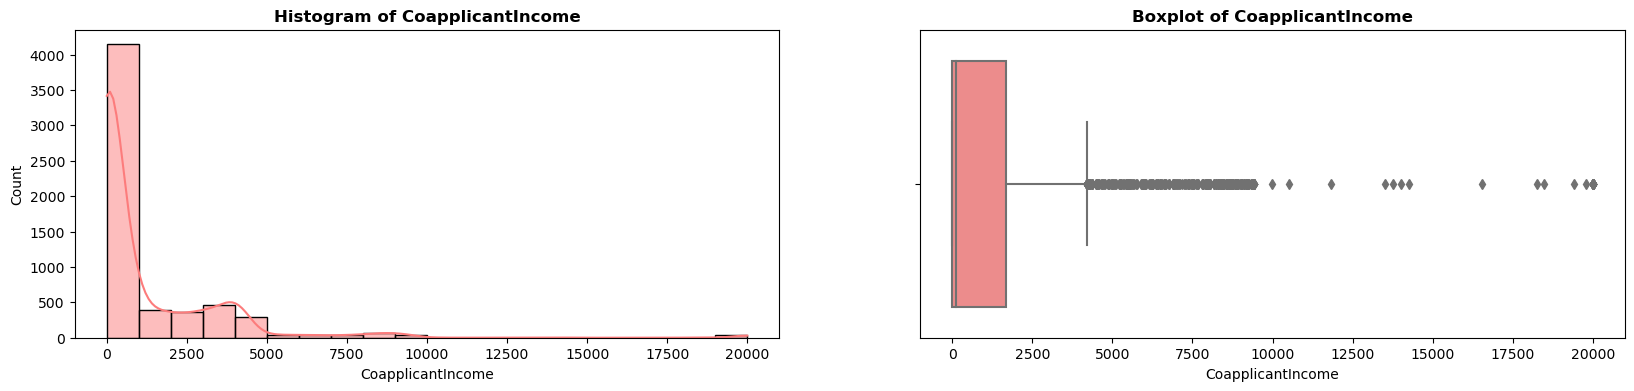

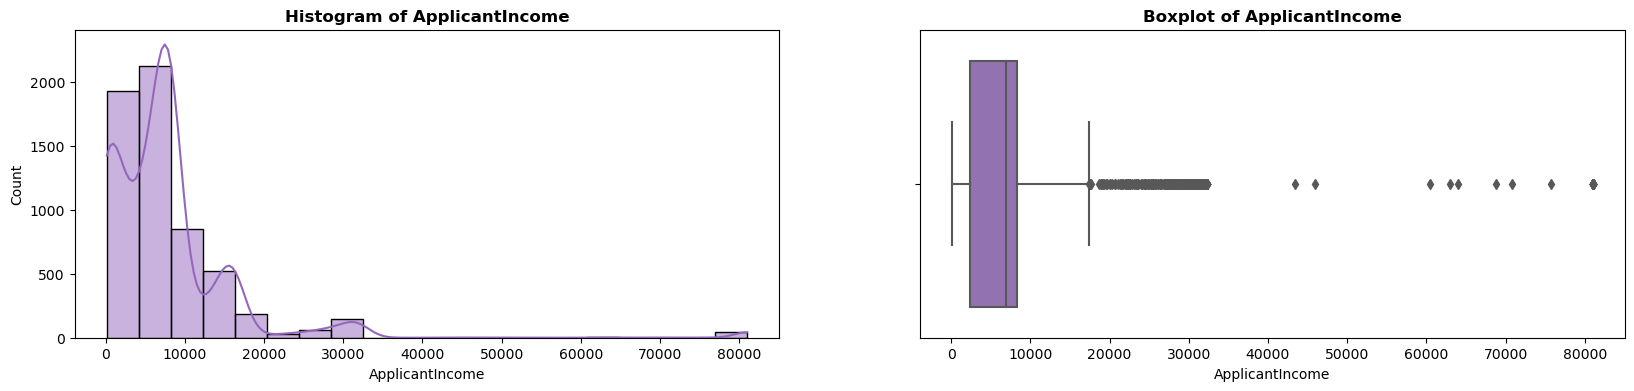

In [9]:
colours = ['#1f77b4', '#fc6c44', '#2b8a2b', '#fc7c7c', '#9467bd', '#4ba4ad', '#c7ad18', '#7f7f7f', '#69d108', '#1f77b4', '#fc6c44', '#2b8a2b','#fc7c7c', '#9467bd', '#4ba4ad','#c7ad18', '#7f7f7f', '#69d108', '#1f77b4', '#fc6c44', '#2b8a2b','#fc7c7c', '#9467bd', '#4ba4ad','#2b8a2b', '#fc7c7c', '#9467bd', '#4ba4ad', '#c7ad18', '#7f7f7f', '#69d108', '#1f77b4']



def univariateAnalysis_numeric(column, nbins, color):
    fig, axes = plt.subplots(1, 2, figsize=(20, 4))

    # Plot histogram
    sns.histplot(train[column], bins=nbins, kde=True, ax=axes[0], color=color)
    axes[0].set_title("Histogram of " + column, fontweight='bold')

    # Plot boxplot
    sns.boxplot(x=train[column], ax=axes[1], color=color)
    axes[1].set_title("Boxplot of " + column, fontweight='bold')

    plt.show()

# Assuming 'df' is your existing DataFrame and 'df_num' is a list of numeric columns
for i, x in enumerate(numerical_columns):
    univariateAnalysis_numeric(x, 20, colours[i])

In [10]:
skew_list = []
def skwenness (df):
    for col in numerical_columns:
        skew_value = df[col].skew()
        skew_list.append(skew_value)
    return pd.DataFrame({"columns": numerical_columns,
                        "Skewness":skew_list})

skwenness(train)

,columns,Skewness
0,LoanAmount,1.486722
1,Loan_Amount_Term,-4.804779
2,Total_Income,3.972166
3,CoapplicantIncome,3.902062
4,ApplicantIncome,4.457577


In [11]:
def replacement (df):
    df['Dependents'] = df['Dependents'].replace({ "3+" : 3}).astype("str")
    df ['Property_Area'] = df['Property_Area'].astype('str')
    df = df.drop(columns = ['ID',])
    return df 

train = replacement(train)
test = replacement(test)

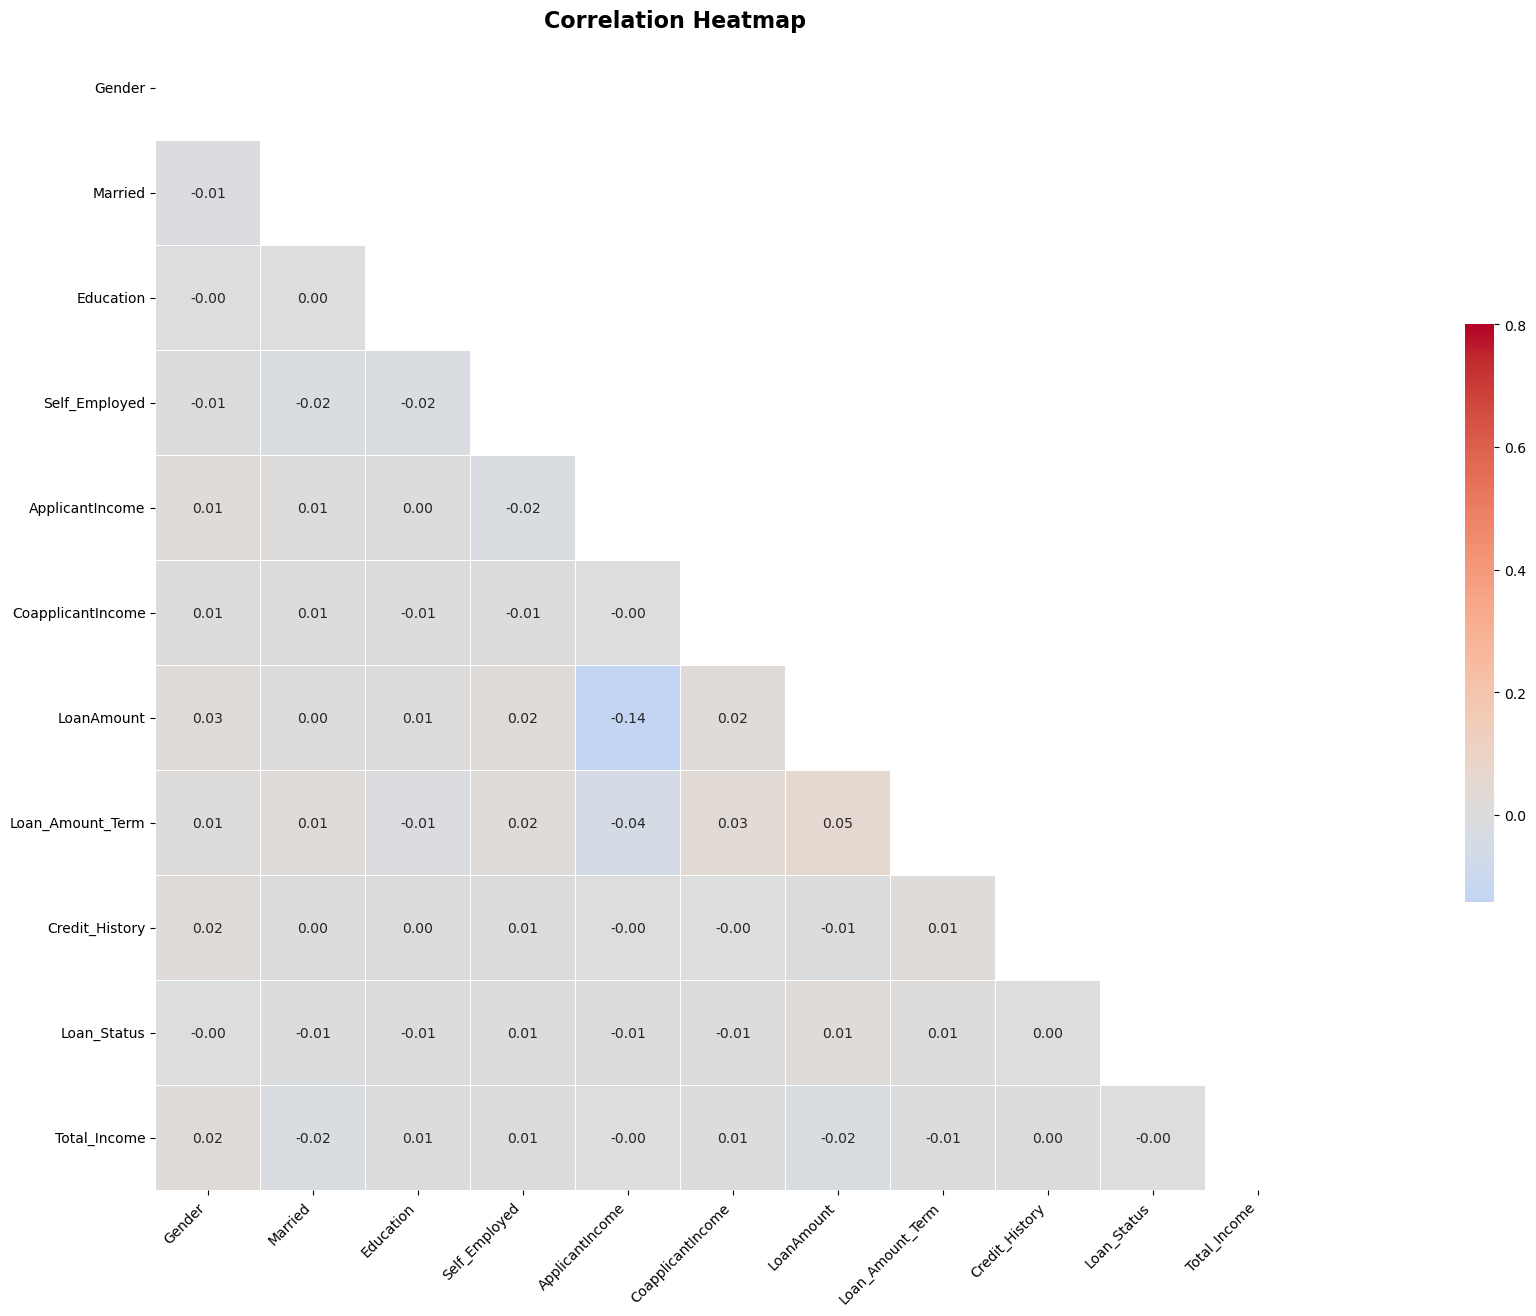

In [12]:
#CORRELATION BETWEEN THE INDEPENDENTS FEATURES AND THE TARGETS COLUMNS
#HEATMAP PLOT 

corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(40, 15))

heatmap = sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.8, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

title = heatmap.set_title("Correlation Heatmap", weight='bold', size=16)
title.set_position([0.45, 1.1])
plt.show()

In [13]:

def Frequency_Encoding(df):
    
    # Calculate frequency of each Loan_ID
    frequency_encoding = df['Loan_ID'].value_counts()
    # Map frequencies to the original DataFrame
    df['Loan_ID'] = df['Loan_ID'].map(frequency_encoding)
    return df
train = Frequency_Encoding(train)
test = Frequency_Encoding(test)

In [14]:
# determine the mutual information for numerical features

mutual_df = train.drop(columns =['Loan_Status'])
y_sampled = train['Loan_Status']
mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state= 42)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
Total_Income,0.009667
Loan_Amount_Term,0.008412
ApplicantIncome,0.007855
CoapplicantIncome,0.007665
Self_Employed,0.002551
Loan_ID,0.002104
Property_Area,0.001697
Education,0.001374
Credit_History,0.001248
Gender,0.000000


In [15]:
def feature_transformation(df):
    df['LoanAmount']  = np.log1p (df['LoanAmount'] )
    df['CoapplicantIncome'] = np.log1p (df['CoapplicantIncome'] )
    df['ApplicantIncome'] = np.power (df['ApplicantIncome'] ,1/3)
    return df
train = feature_transformation(train)
test = feature_transformation(test)

In [16]:
def Normalization(df):
    scaler = StandardScaler()
    for col in numerical_columns:
        df[col] = scaler.fit_transform(df[[col]])
        #df['Loan_ID'] = scaler.fit_transform(df[['Loan_ID']] )
    return df    

train = Normalization(train)
test = Normalization(test)

In [17]:
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [18]:
train.drop_duplicates(inplace = True)
y = train['Loan_Status']
X = train.drop(columns = ['Loan_Status'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2024, stratify=y )

In [19]:
#selected_features = selected_features.to_list()
model_dict = {
    'Logistic' : LogisticRegression(),
    "support_vector" : SVC(),
    'Random_forest' : RandomForestClassifier(random_state= 2024),
    'Catboost': CatBoostClassifier(random_state = 2024 , verbose = False),
    'Xgboost': XGBClassifier(random_state= 2024),
    'Lgbm': LGBMClassifier(random_state = 2024, verbose=-1)
}

In [20]:
Accuracy_list = []
model_list = []

def best_model (model_dict):
    for model_name, model in model_dict.items():
        ##Model fiting and prediction
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        ##Model Evaluation
        accuracy = accuracy_score(y_test, y_pred)
        Accuracy_list.append(accuracy)
        model_list.append(model_name)
        
    return pd.DataFrame({'Accuracy_Score': Accuracy_list}, index = model_list)

result = best_model(model_dict)
result.sort_values(by = 'Accuracy_Score', ascending=True)

,Accuracy_Score
Xgboost,0.817627
Lgbm,0.830508
Catboost,0.832542
Logistic,0.833220
support_vector,0.833220
Random_forest,0.834576


In [21]:
rdf = RandomForestClassifier(random_state=2024)
rdf.fit(X_train, y_train)
y_pred = rdf.predict(X_test)
score  = accuracy_score(y_test, y_pred)
print(f"Accuracy Score {score}")

test_preds = rdf.predict(test)


Accuracy Score 0.8345762711864407


In [22]:
sample_submission = pd.read_csv('Sample Submission.csv')
sample_submission['Loan_Status'] = test_preds
sample_submission.to_csv('submission_rerun_random_forest.csv', index=False)
sample_submission.head(10)

,ID,Loan_Status
0,70607,1
1,58412,1
2,88755,1
3,97271,1
4,70478,1
5,19108,1
6,29374,1
7,28476,1
8,63397,1
9,97950,1


In [23]:
import pickle

# Assuming your trained Random Forest classifier is named `rf_model`
with open('rdf.pkl', 'wb') as file:
    pickle.dump(rdf, file)

In [24]:
import joblib

# Save the model with joblib
joblib.dump(rdf, 'rdf.joblib')

['rdf.joblib']